- author: 杨航锋
- date: 2018.11.5

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
nltk.download('stopwords') #used once to download stopwords.
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yhf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 数据预处理

In [5]:
data = pd.DataFrame()
label, content = [], []
with open("./smsspamcollection/SMSSpamCollection", "r", encoding="utf-8") as fp:
    email_list = fp.readlines()
for emails in email_list:
    email = emails.split("\t")
    label.append(email[0].strip())
    content.append(email[1].strip())
data["content"] = content
data["label"] = label

In [6]:
data.head()

,content,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
content    5574 non-null object
label      5574 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [115]:
# Cleaning the data
import string

corpus = []
for i in range(0,5574):
    smsDocument = re.sub(r'[{}|\d+]'.format(string.punctuation),' ',content[i])
    smsDocument = smsDocument.lower()
    smsDocument = smsDocument.split()
    ps = PorterStemmer()
    smsDocument = [ps.stem(word) for word in smsDocument if not word in set(stopwords.words('english'))]
    smsDocument = ' '.join(smsDocument)
    corpus.append(smsDocument)

In [117]:
smsDocuments = pd.Series(corpus)

In [118]:
vectorizer = CountVectorizer(max_features=3000) 
vector = vectorizer.fit_transform(smsDocuments).toarray()

In [119]:
clear_email_data = pd.DataFrame(vector, columns = vectorizer.get_feature_names())

In [120]:
clear_email_data["label"] = label

In [121]:
convert = lambda s: 1 if s == "ham" else 0
clear_email_data["label"] = clear_email_data["label"].apply(convert)

In [122]:
clear_email_data.head()

,aah,aathi,abi,abiola,abl,abt,abta,ac,acc,accept,...,yoga,yogasana,yor,yr,yummi,yun,yuo,yup,zed,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [123]:
training_data, testing_data, y_train, y_test = train_test_split(clear_email_data.iloc[:, :-1], clear_email_data['label'], test_size=0.30, random_state=0)

### 训练模型

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

Accuracy Score:  0.979677226539
AUC Score:  0.969236389048


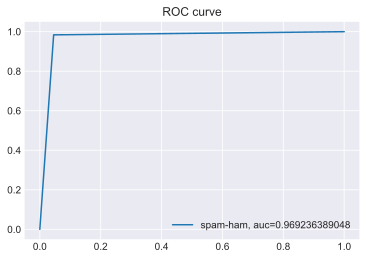

In [124]:
model = MultinomialNB() #Multinomail distribution (naive bayes classification) works better in case of counts.
model.fit(training_data, y_train)
pred = model.predict(testing_data)
accs = accuracy_score(y_test, pred)
print("Accuracy Score: ", accs)
fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
auc = metrics.roc_auc_score(y_test, pred) #Find AUC score for the data set based on LR
print("AUC Score: ", auc)
_ = plt.plot(fpr, tpr, label="spam-ham, auc="+str(auc))
_ = plt.legend(loc=4)
_ = plt.title("ROC curve")

Accuracy Score:  0.982078853047
AUC Score:  0.966579621954


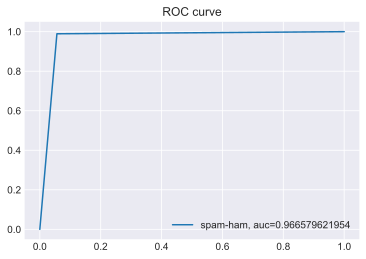

In [40]:
model = MultinomialNB() #Multinomail distribution (naive bayes classification) works better in case of counts.
model.fit(training_data, y_train)
pred = model.predict(testing_data)
accs = accuracy_score(y_test, pred)
print("Accuracy Score: ", accs)
fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
auc = metrics.roc_auc_score(y_test, pred) #Find AUC score for the data set based on LR
print("AUC Score: ", auc)
_ = plt.plot(fpr, tpr, label="spam-ham, auc="+str(auc))
_ = plt.legend(loc=4)
_ = plt.title("ROC curve")

In [41]:
target_names = ['spam', 'ham']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

       spam       0.94      0.94      0.94        89
        ham       0.99      0.99      0.99       469

avg / total       0.98      0.98      0.98       558



In [91]:
def trainNB(train_data, label):
    numTrainDocs = len(train_data) 
    numWords = len(train_data[0])
    pAbusive = sum(label) / np.float(numTrainDocs) 
    p0Num = np.ones(numWords)
    p1Num = np.ones(numWords)
    p0Denom = 2.0
    p1Denom = 2.0
    for i in range(numTrainDocs):
        if label[i] == 1:
            p1Num += train_data[i] 
            p1Denom += sum(train_data[i])
        else: 
            p0Num += train_data[i]
            p0Denom += sum(train_data[i])
    p1Vec = np.log(p1Num / p1Denom)
    p0Vec = np.log(p0Num / p0Denom)
    return p0Vec, p1Vec, pAbusive  

def classifyNB(vec2Classify, p0Vec, p1Vec, pClass1): 
    p1 = sum(vec2Classify * p1Vec) + np.log(pClass1)
    p0 = sum(vec2Classify * p0Vec) + np.log(1.0 - pClass1)
    if p1 > p0:
        return 1
    else: return 0

def byes_predict(p0V, p1V, pAb):
    _predict = []
    for test_data in np.array(testing_data):
        _predict.append(classifyNB(test_data, p0V, p1V, pAb))
    return _predict

In [125]:
training_data, testing_data, y_train, y_test = train_test_split(clear_email_data.iloc[:, :-1], clear_email_data['label'], test_size=0.30, random_state=0)
p0V, p1V, pAb = trainNB(np.array(training_data), np.array(y_train))
predict = byes_predict(p0V, p1V, pAb)

Accuracy Score:  0.963538553497
AUC Score:  0.964952555862


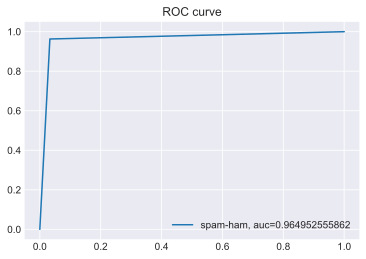

In [126]:
accs = accuracy_score(y_test, predict)
print("Accuracy Score: ", accs)
fpr, tpr, _ = metrics.roc_curve(y_test,  predict)
auc = metrics.roc_auc_score(y_test, predict) #Find AUC score for the data set based on LR
print("AUC Score: ", auc)
_ = plt.plot(fpr, tpr, label="spam-ham, auc=" + str(auc))
_ = plt.legend(loc=4)
_ = plt.title("ROC curve")

### 增量式训练 

In [56]:
training_data, testing_data, y_train, y_test = train_test_split(clear_email_data.iloc[:, :-1], clear_email_data['label'], test_size=0.10, random_state=0)

In [60]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5016 entries, 1683 to 2732
Columns: 3000 entries, aah to zoe
dtypes: int64(3000)
memory usage: 114.8 MB


In [76]:
accs = []
for i in range(1000, 5016, 1000):
    model = MultinomialNB() #Multinomail distribution (naive bayes classification) works better in case of counts.
    model.fit(training_data[:i], y_train[:i])
    pred = model.predict(testing_data)
    accs.append(accuracy_score(y_test, pred))

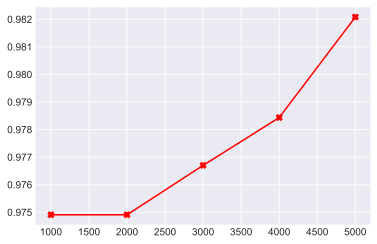

In [88]:
x = range(1000, 5016, 1000)
fig, ax = plt.subplots()
ax.plot(x, accs, 'rX-')

In [96]:
predict = []
for i in range(1000, 5016, 1000):
    p0V, p1V, pAb = trainNB(np.array(training_data)[:i], np.array(y_train)[:i])
    acc = accuracy_score(y_test, byes_predict(p0V, p1V, pAb))
    predict.append(acc)

Text(0,0.5,'accuracy')

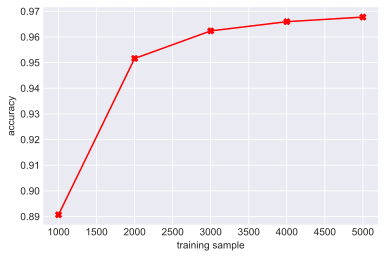

In [99]:
x = range(1000, 5016, 1000)
fig, ax = plt.subplots()
ax.plot(x, predict, 'rX-')
plt.xlabel("training sample")
plt.ylabel("accuracy")

In [31]:
from sklearn.metrics import classification_report

In [35]:
target_names = ['spam', 'ham']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

       spam       0.91      0.95      0.93       242
        ham       0.99      0.98      0.99      1431

avg / total       0.98      0.98      0.98      1673



In [106]:
from sklearn.linear_model import LogisticRegression

In [104]:
training_data, testing_data, y_train, y_test = train_test_split(clear_email_data.iloc[:, :-1], clear_email_data['label'], test_size=0.30, random_state=0)

Accuracy Score:  0.979079497908
AUC Score:  0.934552789184


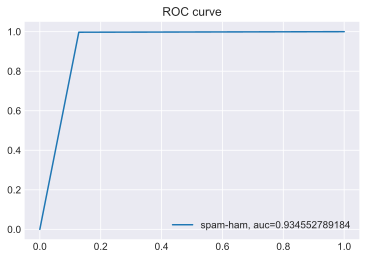

In [107]:
model = LogisticRegression()
model.fit(training_data, y_train)
pred = model.predict(testing_data)
accs = accuracy_score(y_test, pred)
print("Accuracy Score: ", accs)
fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
auc = metrics.roc_auc_score(y_test, pred) #Find AUC score for the data set based on LR
print("AUC Score: ", auc)
_ = plt.plot(fpr, tpr, label="spam-ham, auc="+str(auc))
_ = plt.legend(loc=4)
_ = plt.title("ROC curve")

In [108]:
target_names = ['spam', 'ham']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

       spam       0.98      0.87      0.92       242
        ham       0.98      1.00      0.99      1431

avg / total       0.98      0.98      0.98      1673



In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000) 
vector = vectorizer.fit_transform(smsDocuments).toarray()

Accuracy Score:  0.979677226539
AUC Score:  0.969236389048


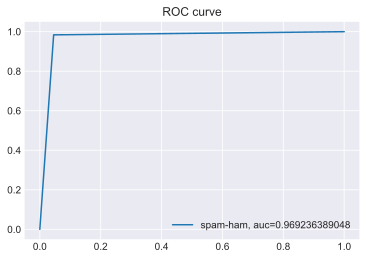

In [140]:
training_data, testing_data, y_train, y_test = train_test_split(clear_email_data.iloc[:, :-1], clear_email_data['label'], test_size=0.30, random_state=0)
model = MultinomialNB() #Multinomail distribution (naive bayes classification) works better in case of counts.
model.fit(training_data, y_train)
pred = model.predict(testing_data)
accs = accuracy_score(y_test, pred)
print("Accuracy Score: ", accs)
fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
auc = metrics.roc_auc_score(y_test, pred) #Find AUC score for the data set based on LR
print("AUC Score: ", auc)
_ = plt.plot(fpr, tpr, label="spam-ham, auc="+str(auc))
_ = plt.legend(loc=4)
_ = plt.title("ROC curve")

In [141]:
target_names = ['spam', 'ham']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

       spam       0.91      0.95      0.93       242
        ham       0.99      0.98      0.99      1431

avg / total       0.98      0.98      0.98      1673



In [300]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras import layers, models
import keras

In [266]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [267]:
X_train = X_train.reshape(X_train.shape[0], -1) / 255.   # normalize
X_test = X_test.reshape(X_test.shape[0], -1) / 255.      # normalize
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

In [331]:
model = models.Sequential()
model.add(layers.Dense(10, activation="relu", input_shape=(784, )))
model.add(layers.Dense(10, activation="softmax"))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [332]:
model.fit(X_train, y_train, epochs=3, batch_size=128)

Epoch 1/3
60000/60000 [==============================] - 1s 23us/step - loss: 0.7286 - acc: 0.7956
Epoch 2/3
60000/60000 [==============================] - 1s 22us/step - loss: 0.3384 - acc: 0.9043
Epoch 3/3
60000/60000 [==============================] - 1s 19us/step - loss: 0.2961 - acc: 0.9154


In [333]:
y = model.predict(X_test[:2])

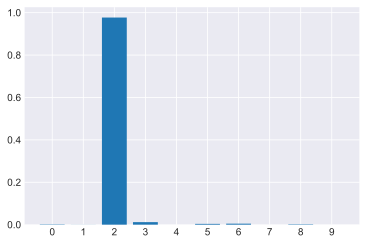

In [339]:
x = np.arange(10)
fig, ax = plt.subplots()
ax.bar(x, y[1])
_ = plt.xticks(x)

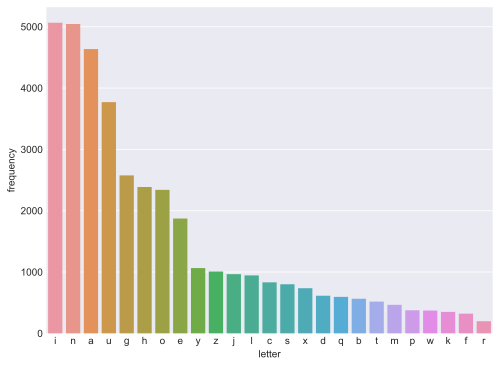

In [472]:
import re
import collections

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def split_data():
    with open("kXHC1983.txt", "r", encoding="utf-8") as fp:
        pingyin_lists = fp.readlines()
    pingyins = ""
    for pingyin in pingyin_lists:
        pingyins += pingyin.split()[1]
    return pingyins

def replace(pingyins):
    pingyins = re.sub("[{}]".format("āáǎà"), "a", pingyins)
    pingyins = re.sub("[{}]".format("ōó̀ǒò"), "o", pingyins)
    pingyins = re.sub("[{}]".format("ǜùǔǚüūǘú"), "u", pingyins)
    pingyins = re.sub("[{}]".format("īíǐì"), "i", pingyins)
    pingyins = re.sub("[{}]".format("ēéěè"), "e", pingyins)
    pingyins = re.sub("[{}]".format("ńňǹ"), "n", pingyins)
    pingyins = re.sub("[{}]".format(",ḿ"), "", pingyins)
    return pingyins

pingyins = split_data()
pingyin = replace(pingyins)
alpha_dict = collections.Counter(pingyin)
data = pd.DataFrame()
data["letter"] = list(alpha_dict.keys())
data["frequency"] = list(alpha_dict.values())
sorted_data = data.sort_values(by="frequency", ascending=False)
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="letter", y="frequency", data=sorted_data)

In [14]:
0b111111111111111111111111111111

1073741823

In [15]:
help(np.stack)

Help on function stack in module numpy.core.shape_base:

stack(arrays, axis=0)
    Join a sequence of arrays along a new axis.
    
    The `axis` parameter specifies the index of the new axis in the dimensions
    of the result. For example, if ``axis=0`` it will be the first dimension
    and if ``axis=-1`` it will be the last dimension.
    
    .. versionadded:: 1.10.0
    
    Parameters
    ----------
    arrays : sequence of array_like
        Each array must have the same shape.
    axis : int, optional
        The axis in the result array along which the input arrays are stacked.
    
    Returns
    -------
    stacked : ndarray
        The stacked array has one more dimension than the input arrays.
    
    See Also
    --------
    concatenate : Join a sequence of arrays along an existing axis.
    split : Split array into a list of multiple sub-arrays of equal size.
    block : Assemble arrays from blocks.
    
    Examples
    --------
    >>> arrays = [np.random.randn(3,

In [16]:
1024 * 20

20480